In [37]:
from tensorflow import keras 
import numpy as np # linear algebra  
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import os
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional # , TimeDistributed
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD


In [38]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [39]:
#data_dir = os.path.join('data', 'conll03')
train = pd.read_csv("C:\\Users\\Aina\\Documents\\CATTOLICA\\SECONDO ANNO\\DATA VISUALIZATION AND TEXT MINING\\text\\project\\new_train2.csv")
test = pd.read_csv("C:\\Users\\Aina\\Documents\\CATTOLICA\\SECONDO ANNO\\DATA VISUALIZATION AND TEXT MINING\\text\\project\\new_test2.csv")

In [40]:
#GIULIA
#train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progetto text mining/new_train2.csv')
#test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progetto text mining/new_test2.csv')

#FRA
#train = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_train2.csv')
#test = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_test2.csv')

In [41]:
#questo per togliere righe vuote!!!

train.isnull().sum()
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
train.isnull().sum()

test.isnull().sum()
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)
test.isnull().sum()


label     0
review    0
dtype: int64

#Neural Network model for classification

# LSTM for classification 


Here we start the processing of the data in order to be prepared for implementing a BiLSTM model.
Since the data of the train and test we need to be in the exact same format, we put together in a unique dataframe called 'df'.

In [42]:
#COMMENTO QUESTE DUE RIGHE PER NON FARLO SUL 10% DEL DATASET
#train,train_extra = train_test_split(train, test_size = 0.90, random_state = 42)
#test, test_extra = train_test_split(test, test_size = 0.90, random_state = 42)


frames = [train, test]
df = pd.concat(frames, ignore_index = True)
print(df.shape[0])
print(train.shape[0])
print(test.shape[0])

df.info()
df.tail()

699940
649941
49999
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699940 entries, 0 to 699939
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   699940 non-null  int64 
 1   review  699940 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.7+ MB


,label,review
699935,1,wanted write review chip said not recommend go...
699936,5,great ambience great drinks great food love place
699937,4,monks locations excited heard coming sun prair...
699938,2,not know want try but good reviews people sadl...
699939,1,buffet recently open renovation husband thinki...


Data has already been filtered so only valid texts and words remain.  Then, I use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'].values)
X = tokenizer.texts_to_sequences(df['review'].values)
print(X[0:4])

[[763, 36739, 1163, 114, 872, 13233, 9, 392, 522, 9065, 6, 752, 3296, 9803, 1277, 2147, 78735, 1433, 865, 1234, 585, 1494, 86, 3207, 13329, 13053, 169, 86, 336, 191, 32, 1174, 8007, 5077], [404, 4235, 763, 36739, 1482, 1900, 39, 3086, 2241, 2, 1243, 306, 34, 34, 602, 3737, 302, 194, 626, 201, 3998, 1308, 1103, 6, 1423, 226, 364, 277, 3086, 487, 1111, 3296, 2866, 423, 4125, 302, 26080, 88, 11437, 2063, 101, 763, 36739, 75], [25, 763, 36739, 142, 32, 1768, 3296, 246, 122270, 7, 142, 76, 1153, 18540, 763, 78736, 69927, 45504, 290, 1482, 2876, 2458, 2289, 40, 871, 3290, 1423, 383, 6306, 3458, 2866, 1507, 446], [8, 3568, 2072, 230, 20, 763, 36739, 1064, 1097, 48, 4443, 3464, 1375, 32, 1177, 48, 1243, 2241, 100, 4, 529, 191, 631]]


The vocabulary size counts how many different words we have, in our case 77547, since it's a very big number as features for the Neural Network we decided to use only 20000 features and use again a Tokenizer to vectorize and convert text into sequences but only for 20000 words.

In [8]:
vocabulary_size = len(tokenizer.word_counts)
print(vocabulary_size)

237913


In [9]:
#max_features=20000
#tokenizer = Tokenizer(num_words=max_features, split=' ')
#tokenizer.fit_on_texts(df['review'].values)
#X = tokenizer.texts_to_sequences(df['review'].values)

In [10]:
#len(tokenizer0.word_counts)

Now we divide again into train and test and we call X_train the reviews for the train and X_test the reviews of the test. Then we take the label values of the train and test to create Y_train and Y_test which contains a number from 1 to 5 for each review, so the different classes where the reviews are classify.

In [11]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [12]:
Y_train = pd.get_dummies(train['label']).values
Y_test = pd.get_dummies(test['label']).values

#print(Y_train)
#print(X_train)

Let's now consider the **lengths** (number of tokens) for each review, we can see that 95% of the reviews has a length of maximum 158, so we set maxlen=158, that is a parameter that we'll use later when we transform into **pad sequences**, in order to cut reviews that are longer than that, and we assign zero to the remaining slot of tokens for shorter reviews. 

In [13]:
sequence_len = np.array([len(s) for s in X_train])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 867
[('75%', 75.0), ('80%', 86.0), ('85%', 100.0), ('90%', 121.0), ('95%', 158.0), ('100%', 867.0)]


In [14]:
X = pad_sequences(X, maxlen=160)   #prima non c'era maxlen=63 (95 quantile )   # vecchio tentativo: maxlen=250
print(df[0:4]["review"])

0    dr goldberg offers look general practitioner n...
1    unfortunately frustration dr. goldberg patient...
2    going dr. goldberg years think 1st patients st...
3    got letter mail week said dr. goldberg moving ...
Name: review, dtype: object


In [15]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [16]:
print(X.shape[1])
print(X_train.shape[1])

print(X.shape)

print(X[10])
#print(X_test[3])
#print(X_train[100])

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

160
160
(699940, 160)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 12303  1129
  1142   148   509  6263     4  3308  2447   117    32   130  1129  1142
   134  6832   123  1743  4222   201   853    86    11 30073   945 52188
  1743     3  3519  3087 11905  1985   523  1726   230 12886  1539   576
  6832   114     4  1682 11795   244   108  4497 19993   186  2896  8610
  3491   118   522   201     3  5651  1181   820  7261  1743 13615   384
   156  2006  2750   425   249    49  1129  1142 78737  1573 92954   146
 22769  4115  3087  1142  7872   279     2  6082  1087   176   100  3062
  1717   205   698   110     3   964    19   500   293  3514   100  1423
   117     5 13795  1092]
(64

In [17]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [18]:
max_sequence_len=160

Before implementing the model we create the **Word Embedding** matrix using **GloVe**, that we used as embedding layer for the tokens. GloVe allows us to have vectors of numbers that describe the similarities of the words, so wors that are similar or represent similar concepts would have similar numbers escribing it.
We took a pre-trained vector of word embedding that is contained in the file "glove.6B.100d.txt", that uses 100 features, and reading line by line select the lines with the words that are contained in the tokenizer of Keras.
In this case we used GloVe (Global Vectors words representation) implementation instead of Word2Vect because it is an improvement of it. 

In [19]:
embeddings_index = {}
#glove_embedding_path = pd.read_csv('/content/drive/MyDrive/progetto text mining/glove.6B.100d.txt')
glove_embedding_path = os.path.join('embeddings', 'glove.6B.100d.txt')
embed_dim=100
word_index = tokenizer.word_index
with open(glove_embedding_path, "r", encoding='iso-8859-1') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index)+1, embed_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
    
glove_matrix = embedding_matrix

Found 399884 word vectors.


Next, I implement the **BiLSTM** Network, where the notation Bi is because we have two hidden layers. The model is construct in the following way:
* first of all we add the embedding layer, using GloVe as told before,
* we had to add a Dropout layer in order to avoid overfitting problems, setting a dropout value of 0.7, for smoothing the behaviour of the Neural Network
* then we used a bidirectional LSTM layer, so that takes into consideration the sequence of tokns not only from left to right but also from right to left, using 2 hidden layers
* finally the Dense layer, with 5 ad number of output, that uses **softmax** as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that, also because we have to handle multiple classes.

Note that we have some variables that are hyperparameters:
* **embed_dim**, which we said being 100 because of the pre-trained GloVe word embedding
* **lstm_out** which, **droupout** variables are hyperparameters, to most of them we have associated a value by intuition. 


In [20]:
#glove_embedding_path = pd.read_csv('/content/drive/MyDrive/progetto text mining/glove.6B.100d.txt',header = None)
#embed_dim = 100
#glove_matrix = load_glove_embedding_matrix(glove_embedding_path, tokenizer.word_index, embed_dim)

In [21]:
lstm_out = 100  

model = Sequential()

model.add(Embedding(vocabulary_size+1, embed_dim, 
                    weights=[glove_matrix], input_length=X_train.shape[1], # same as maxlen
                    trainable=False))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.7)))

model.add(Dense(5, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       Precision(),
                       Recall()])
model.summary()

early_stopping_callback = EarlyStopping(monitor="loss", min_delta=0.01, 
                                        patience=3, verbose=1, mode="auto", 
                                        restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 100)          23791400  
                                                                 
 dropout (Dropout)           (None, 160, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
Total params: 23,953,205
Trainable params: 161,805
Non-trainable params: 23,791,400
_________________________________________________________________


Now it's time to train the Network, we tried with **batch_size** = 256 and 10 **epochs** since the time for each epoch was very high. We also added an early stopping callback so that if the loss doesn't change much from the previous epoch the run interrumps. The variable **verbose** setted equal to 1 means that we want to visualize the bar of progress moving and we see one line per epoch.

In [22]:
batch_size = 256
history = model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, 
                    validation_split=0.2, callbacks=[early_stopping_callback]) 

Epoch 1/15
2032/2032 [==============================] - 3244s 2s/step - loss: 1.4662 - accuracy: 0.3393 - precision: 0.6138 - recall: 0.0564 - val_loss: 1.2668 - val_accuracy: 0.4502 - val_precision: 0.7612 - val_recall: 0.1575
Epoch 2/15
2032/2032 [==============================] - 2855s 1s/step - loss: 1.4116 - accuracy: 0.3710 - precision: 0.6328 - recall: 0.0824 - val_loss: 1.2252 - val_accuracy: 0.4763 - val_precision: 0.7937 - val_recall: 0.1462
Epoch 3/15
2032/2032 [==============================] - 2764s 1s/step - loss: 1.3941 - accuracy: 0.3815 - precision: 0.6358 - recall: 0.0918 - val_loss: 1.1948 - val_accuracy: 0.4897 - val_precision: 0.7697 - val_recall: 0.1864
Epoch 4/15
2032/2032 [==============================] - 2774s 1s/step - loss: 1.3843 - accuracy: 0.3861 - precision: 0.6413 - recall: 0.0964 - val_loss: 1.1766 - val_accuracy: 0.4993 - val_precision: 0.7805 - val_recall: 0.2004
Epoch 5/15
2032/2032 [==============================] - 2773s 1s/step - loss: 1.3787 - a

In [ ]:
#%%time

#batch_size = 256
#history = model.fit(X_train, 
#          Y_train, 
#          batch_size=batch_size, 
#          epochs=3,
#          verbose=2,
#          callbacks=[early_stopping_callback]
#         )

In [23]:
model.save('model_normal_7epoch_totale.h5')

Finally we have the model trained, so we can test it using the data of the X_test.

In [24]:
 predictions = model.predict(X_test)

In [25]:
predictions

array([[0.63811034, 0.11361138, 0.04535076, 0.0331994 , 0.16972809],
       [0.56514055, 0.19395363, 0.11478624, 0.0555003 , 0.07061926],
       [0.86406356, 0.12280075, 0.0099284 , 0.0020891 , 0.00111826],
       ...,
       [0.02302444, 0.14353554, 0.3545451 , 0.36434236, 0.1145526 ],
       [0.09811168, 0.32404408, 0.3159204 , 0.20104872, 0.0608751 ],
       [0.21051511, 0.49640664, 0.22437102, 0.05670108, 0.0120062 ]],
      dtype=float32)

In [26]:
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([0, 0, 0, ..., 3, 1, 1], dtype=int64)

One of the most important metrics we would like to see is the accuracy, in our case is not very hgh, probably for the small number of epochs, but it's not so bad.

In [27]:
score, acc, *is_anything_else_being_returned = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

196/196 - 53s - loss: 1.1907 - accuracy: 0.4857 - precision: 0.7474 - recall: 0.1626 - 53s/epoch - 269ms/step
acc: 0.49


We can visualize the confusion matrix also through a heatmap.


In [28]:
from sklearn.metrics import confusion_matrix,classification_report

In [29]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

In [30]:
cf_matrix

array([[6758, 2077,  618,  211,  335],
       [2313, 3826, 2720,  735,  406],
       [ 691, 1936, 4590, 2169,  614],
       [ 297,  716, 2855, 4346, 1786],
       [ 368,  436,  967, 3465, 4764]], dtype=int64)

In [31]:
import seaborn as sns

#group_names = ['True Neg','False Pos','False Neg','True Pos', ]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

<AxesSubplot:>

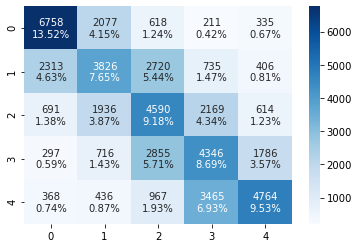

In [32]:
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [33]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      9999
           1       0.43      0.38      0.40     10000
           2       0.39      0.46      0.42     10000
           3       0.40      0.43      0.42     10000
           4       0.60      0.48      0.53     10000

    accuracy                           0.49     49999
   macro avg       0.49      0.49      0.49     49999
weighted avg       0.49      0.49      0.49     49999



The conclusion of this test is that our model it's not extremely good, it could be improved, but it needs more time to do that. Although for the extreme classes (1 and 5) has a better performance, quite good, in respect to the others.

Let's try it in action, we try with a single text of a review (written by us) to say how many stars would I selectionate corresponding to that.

In [34]:
twt = ['The resturant was awful. nice waitress but hated the food']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=160, dtype='int32')   #, value=0
print(twt)


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 1883 5248 9206  529
     9  141   82 3011 1883    1]]


In [35]:
sentiment = model.predict(twt,verbose = 2)[0]  

1/1 - 0s - 53ms/epoch - 53ms/step


In [36]:
print("review evaluated as", np.argmax(sentiment)+1, "out of 5")


#if(np.argmax(sentiment) == 0):
#    print("review evaluated as 1 out of 5")
#elif (np.argmax(sentiment) == 1):
#    print("review evaluated as 2 out of 5")
#elif(np.argmax(sentiment) == 2):
#    print("review evaluated as 3 out of 5")
#elif (np.argmax(sentiment) == 3):
##    print("review evaluated as 4 out of 5")
#elif (np.argmax(sentiment) == 4):
#    print("review evaluated as 5 out of 5")

review evaluated as 5 out of 5


The result seems to be right, the review was very bad and the algorithm recognize it.

## Changing categories

Let's try now with a new categorization, with only 3 categories: positive, negative and neutral. We assigned to reviews with label 1 and 2 the **neg** class, to the ones with label 3 the **neut** class and to the ones with 4 or 5 the **pos** class. Since they were unbalanced we reblanced the classes.

In [43]:
train1 = train
train1["cat"] = train1["label"]
train1["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del train1["label"]
print(train1)

                                                   review  cat
0       dr goldberg offers look general practitioner n...  pos
1       unfortunately frustration dr. goldberg patient...  neg
2       going dr. goldberg years think 1st patients st...  pos
3       got letter mail week said dr. goldberg moving ...  pos
4       know dr. goldberg like moving arizona let tell...  neg
...                                                   ...  ...
649936  sprinkler gushing pipe broken way ground turne...  pos
649937  phone calls voicemail messages returned stupid...  neg
649938  looks like good reviews gone head place jason ...  neg
649939  able rely yelp provide needed response leaking...  pos
649940  company months ryan come week needed little re...  neg

[649941 rows x 2 columns]


In [44]:
test1 = test
test1["cat"] = test1["label"]
test1["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del test1["label"]
print(test1)

#COMMENTO QUESTE DUE RIGHE PER NON FARLO SUL 10% DEL DATASET
#train1,train_extra = train_test_split(train1, test_size = 0.90, random_state = 42)
#test1, test_extra = train_test_split(test1, test_size = 0.90, random_state = 42)


                                                  review  cat
0      got new tires weeks got flat took car local me...  neg
1      not waste time different people come house est...  neg
2      worst people place lunch place freezing loaded...  neg
3      restaurant twice disappointed times not time h...  neg
4      food not good husband ate couple weeks ago tim...  neg
...                                                  ...  ...
49994  wanted write review chip said not recommend go...  neg
49995  great ambience great drinks great food love place  pos
49996  monks locations excited heard coming sun prair...  pos
49997  not know want try but good reviews people sadl...  neg
49998  buffet recently open renovation husband thinki...  neg

[49999 rows x 2 columns]


For the train is better if we balance the classes, randomly, since at the end of the cateogirzation we have unbalanced classes.

In [45]:
from sklearn.utils import shuffle
pos_train_subset = train1[train1["cat"]=="pos"].sample(n=len(train1[train1["cat"]=="neut"]),random_state=28)
neut_train_subset = train1[train["cat"]=="neut"]
neg_train_subset = train1[train1["cat"]=="neg"].sample(n=len(train1[train1["cat"]=="neut"]),random_state=98)
print("pos", pos_train_subset.shape, "neu", neut_train_subset.shape, "neg",neg_train_subset.shape)
train_sub = shuffle(pd.concat([pos_train_subset, neut_train_subset, neg_train_subset], ignore_index = True))
train_sub.reset_index(drop=True, inplace=True)
train_sub

pos (129996, 2) neu (129996, 2) neg (129996, 2)


,review,cat
0,occasional drink today stopped lunch sister hu...,neut
1,friends tuesday nights cent taco tuesday speci...,neg
2,evil place end spending money lots shops enter...,pos
3,went moko night craving short ribs bad wait co...,pos
4,hands best place new standard car washing hand...,pos
...,...,...
389983,yummy fast house special chicken orange chicke...,pos
389984,good burgers zucchini root beer floats hit dri...,pos
389985,starting trust yelp rating husband tried place...,neg
389986,cheap beer cheap steak eggs great customer ser...,pos


In [77]:
df_sub = pd.concat([train_sub, test], ignore_index = True)
df_sub = df_sub.sample(n=int(df_sub.shape[0])//42,random_state=8)
#print("pos", df.shape)
df_sub.reset_index(drop=True, inplace=True)

train_sub = train_sub.sample(n=int(train_sub.shape[0])//42,random_state=8)
train_sub.reset_index(drop=True, inplace=True)
test = test.sample(n=int(test.shape[0])//42,random_state=8)
test.reset_index(drop=True, inplace=True)

We proceed in the same way that above. We use Tokenizer, then we transform into pad sequences and we create an embedding matrix using GloVe in order to have it for the embedding layer of the model.

In [78]:
tokenizer2 = Tokenizer() 

In [79]:
tokenizer2.fit_on_texts(df_sub['review'].values)

In [80]:
X = tokenizer2.texts_to_sequences(df_sub['review'].values) 
print(X[0:4]) 

[[1434, 6, 4096, 560, 94, 49, 278, 2, 5, 49, 884, 67, 5, 17772, 47, 18, 11, 5389, 3352, 50, 39, 1694, 3353, 201, 5, 2, 1, 49, 1226, 363, 308, 2442, 313, 11049, 313, 199, 313, 170, 2442, 15, 872, 1604, 21, 247, 5122, 4445, 60, 665, 2852, 2443, 1020, 8526, 168, 76, 2196, 6, 11, 58, 6, 58, 2442, 313, 156, 75, 408, 58, 41, 693, 19, 191, 483, 3089, 2672, 3167, 257, 147, 90, 23, 94, 1091, 184], [1543, 879, 6546, 4446, 149, 879, 6546, 4446, 367, 5123, 9557, 5124, 454, 6547, 770, 417, 2619, 711, 1394, 13415, 17773, 185, 1246, 114, 24], [3, 86, 350, 4447, 405, 260, 560, 4251, 560, 3948, 90, 26, 4447, 86, 6, 224, 1544, 5125, 17774, 2444, 3353], [17775, 111, 5, 7036, 108, 149, 103, 4, 1155, 5697, 17776, 1633, 415, 219, 69, 869, 303, 17777, 9, 3949, 17778]]


In [81]:
vocabulary_size = len(tokenizer2.word_counts)

In [82]:
leng = []
for i in X:
  leng.append(len(i))

In [83]:
import pandas as pd
s = pd.Series(leng)
s.describe() #Non ha senso che facciamo 250 secondo me

count    10475.000000
mean        59.033031
std         52.159875
min          1.000000
25%         24.000000
50%         44.000000
75%         77.000000
max        539.000000
dtype: float64

In [84]:
X = pad_sequences(X, maxlen=160)

In [85]:
X_train = X[:train_sub.shape[0]]
X_test = X[train_sub.shape[0]:]

In [86]:
Y_train = pd.get_dummies(train_sub['cat']).values #Convert categorical variable into dummy/indicator variables.
Y_test = pd.get_dummies(test['cat']).values

We tried the same model, only changing the number of output in the last layer, from 5 to 3.

In [87]:
embeddings_index = {}
#glove_embedding_path = pd.read_csv('/content/drive/MyDrive/progetto text mining/glove.6B.100d.txt')
glove_embedding_path = os.path.join('embeddings', 'glove.6B.100d.txt')
embed_dim=100
word_index = tokenizer2.word_index
with open(glove_embedding_path, "r", encoding='iso-8859-1') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index)+1, embed_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
    
glove_matrix = embedding_matrix

Found 399884 word vectors.


In [88]:
embed_dim =  100
lstm_out = 100  #196
max_features = 160

model = Sequential()

model.add(Embedding(vocabulary_size+1, embed_dim, 
                    weights=[glove_matrix], input_length=X_train.shape[1],trainable=True, mask_zero=True))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.7)))

model.add(Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       Precision(),
                       Recall()])
model.summary()

early_stopping_callback = EarlyStopping(monitor="loss", min_delta=0.01, 
                                        patience=3, verbose=1, mode="auto", 
                                        restore_best_weights=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 160, 100)          3181700   
                                                                 
 dropout_3 (Dropout)         (None, 160, 100)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 3,343,103
Trainable params: 3,343,103
Non-trainable params: 0
_________________________________________________________________


In [89]:
%%time

batch_size = 256
history = model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=2,
          verbose=2,
          callbacks=[early_stopping_callback]
         )

Epoch 1/2
37/37 - 227s - loss: 1.1267 - accuracy: 0.3247 - precision_3: 0.3219 - recall_3: 0.0242 - 227s/epoch - 6s/step
Epoch 2/2
37/37 - 216s - loss: 1.1146 - accuracy: 0.3394 - precision_3: 0.4120 - recall_3: 0.0118 - 216s/epoch - 6s/step
Wall time: 7min 24s


In [ ]:
model.save('model_3cat_10epoch_totale.h5')

We performed prediction.

In [ ]:
predictions = model.predict(X_test)
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
score,acc, *anything_else = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

20/20 - 12s - loss: 0.9998 - accuracy: 0.4675 - precision_2: 0.6063 - recall_2: 0.2939 - 12s/epoch - 593ms/step
acc: 0.47


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

In [ ]:
cf_matrix

array([[1543,  463,   19],
       [ 451,  444,   51],
       [ 717,  961,  350]])

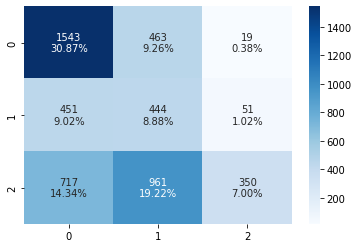

In [ ]:
import seaborn as sns

#group_names = ['True Neg','False Pos','False Neg','True Pos', ]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2025
           1       0.24      0.47      0.32       946
           2       0.83      0.17      0.29      2028

    accuracy                           0.47      4999
   macro avg       0.55      0.47      0.42      4999
weighted avg       0.61      0.47      0.44      4999



As we can see the performance is better than the one with 5 categories.